In [ ]:
!pip install gdown

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [ ]:
import numpy as np
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid',palette='muted', font_scale=1.5)

In [ ]:
rcParams['figure.figsize']=22,10

RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving coalindia.csv to coalindia (1).csv


In [ ]:
df=pd.read_csv('coalindia.csv', parse_dates=['Date'], index_col='Date')

<ipython-input-8-6581fe8b0fd2>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df=pd.read_csv('coalindia.csv', parse_dates=['Date'], index_col='Date')


In [ ]:
df.head()

,Close
Date,
2010-04-11,342.55
2010-05-11,349.85
2010-08-11,330.75
2010-09-11,326.05
2010-10-11,322.80


In [ ]:
df.shape

(2598, 1)

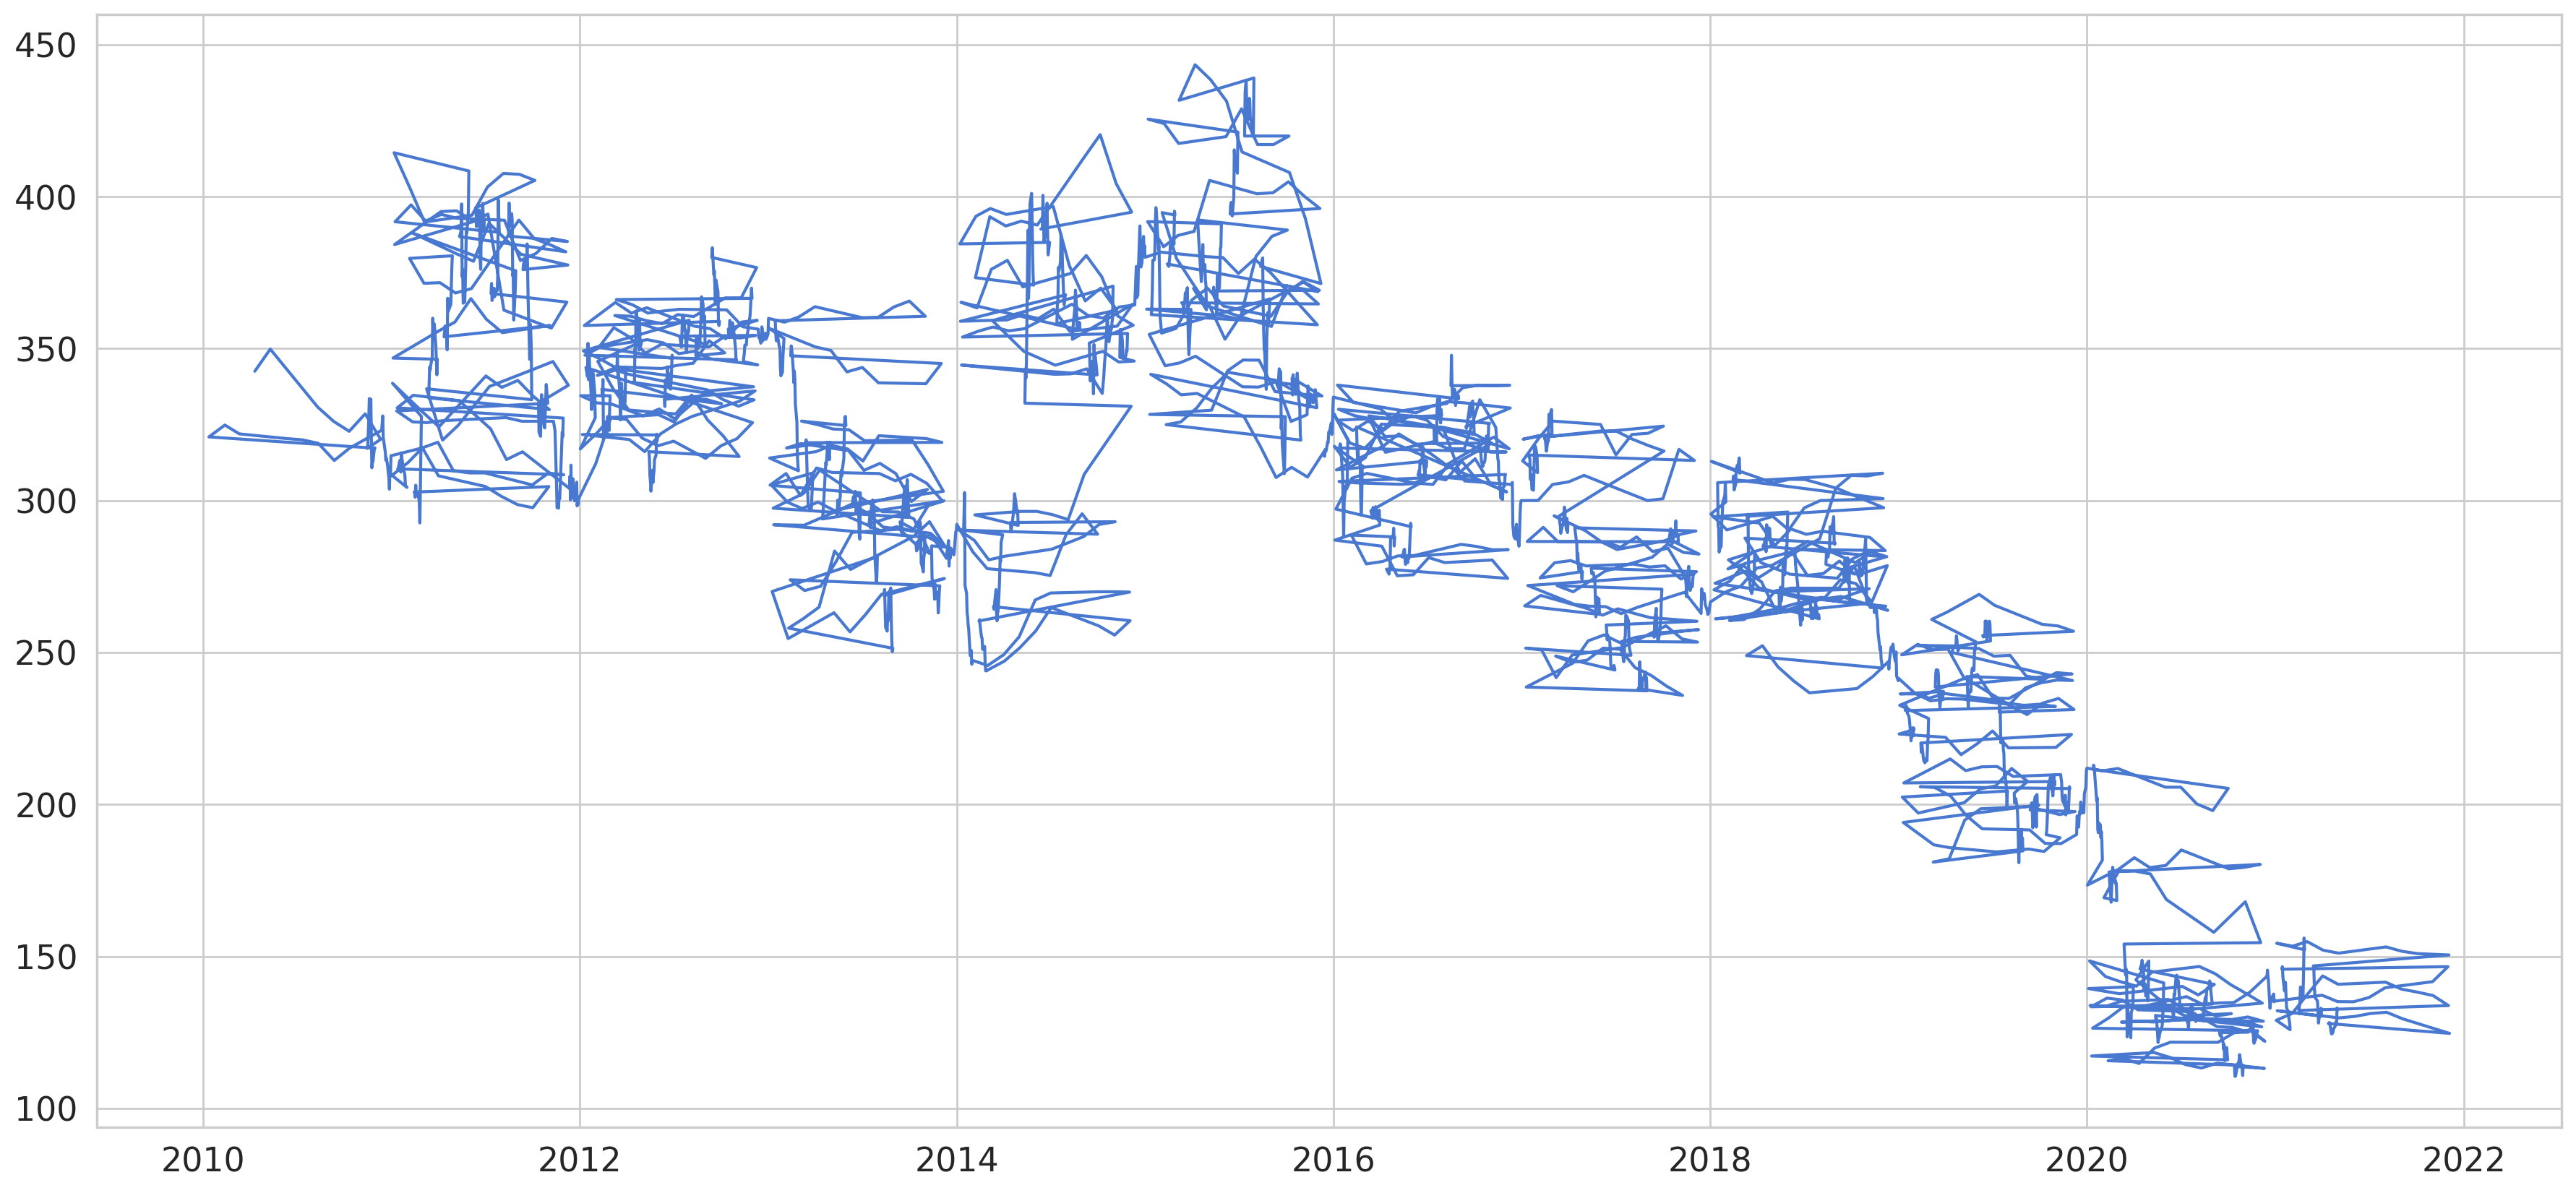

In [ ]:
plt.plot(df,label='Close');

In [ ]:
train_size=int(len(df)*0.95)
test_size=len(df)-train_size
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(2468, 1) (130, 1)


In [ ]:
train,test=df.iloc[0:train_size],df.iloc[train_size:len(df)]
print(train.shape,test.shape)

(2468, 1) (130, 1)


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler=scaler.fit(train[['Close']])

In [ ]:
train['Close']=scaler.transform(train[['Close']])
test['Close']=scaler.transform(test[['Close']])

<ipython-input-15-0723ac4db295>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close']=scaler.transform(train[['Close']])
<ipython-input-15-0723ac4db295>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close']=scaler.transform(test[['Close']])


In [ ]:
train.head()

,Close
Date,
2010-04-11,0.696007
2010-05-11,0.805377
2010-08-11,0.519216
2010-09-11,0.448799
2010-10-11,0.400107


In [ ]:
def create_dataset(x,y,time_steps=1):
  xs,ys=[],[]
  for i in range(len(x)-time_steps):
    v=x.iloc[i:(i+time_steps)].values
    xs.append(v)
    ys.append(y.iloc[i+time_steps])
  return np.array(xs), np.array(ys)


In [ ]:
TIME_STEPS=30
x_train,y_train=create_dataset(train[['Close']],train.Close,TIME_STEPS)
x_test,y_test=create_dataset(test[['Close']],test.Close,TIME_STEPS)


In [ ]:
x_train.shape

(2438, 30, 1)

In [ ]:
#LSTM Autoencoder

model=keras.Sequential()
model.add(keras.layers.LSTM
(
    units=64,input_shape=(x_train.shape[1],x_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=x_train.shape[1]))
model.add(keras.layers.LSTM
(
    units=64,
    return_sequences=True
))

model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(
    units=x_train.shape[2]
)))

model.compile(loss='mae',optimizer='adam')

In [ ]:
history=model.fit(
    x_train,y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
69/69 [==============================] - 12s 19ms/step - loss: 0.2409 - val_loss: 0.4068
Epoch 2/10
69/69 [==============================] - 1s 8ms/step - loss: 0.2356 - val_loss: 0.4208
Epoch 3/10
69/69 [==============================] - 1s 8ms/step - loss: 0.2494 - val_loss: 0.4264
Epoch 4/10
69/69 [==============================] - 1s 9ms/step - loss: 0.2282 - val_loss: 0.2582
Epoch 5/10
69/69 [==============================] - 1s 11ms/step - loss: 0.2236 - val_loss: 0.2845
Epoch 6/10
69/69 [==============================] - 1s 11ms/step - loss: 0.2061 - val_loss: 0.2278
Epoch 7/10
69/69 [==============================] - 1s 12ms/step - loss: 0.2007 - val_loss: 0.2248
Epoch 8/10
69/69 [==============================] - 1s 8ms/step - loss: 0.2020 - val_loss: 0.2083
Epoch 9/10
69/69 [==============================] - 1s 8ms/step - loss: 0.2036 - val_loss: 0.1909
Epoch 10/10
69/69 [==============================] - 1s 8ms/step - loss: 0.1992 - val_loss: 0.2144


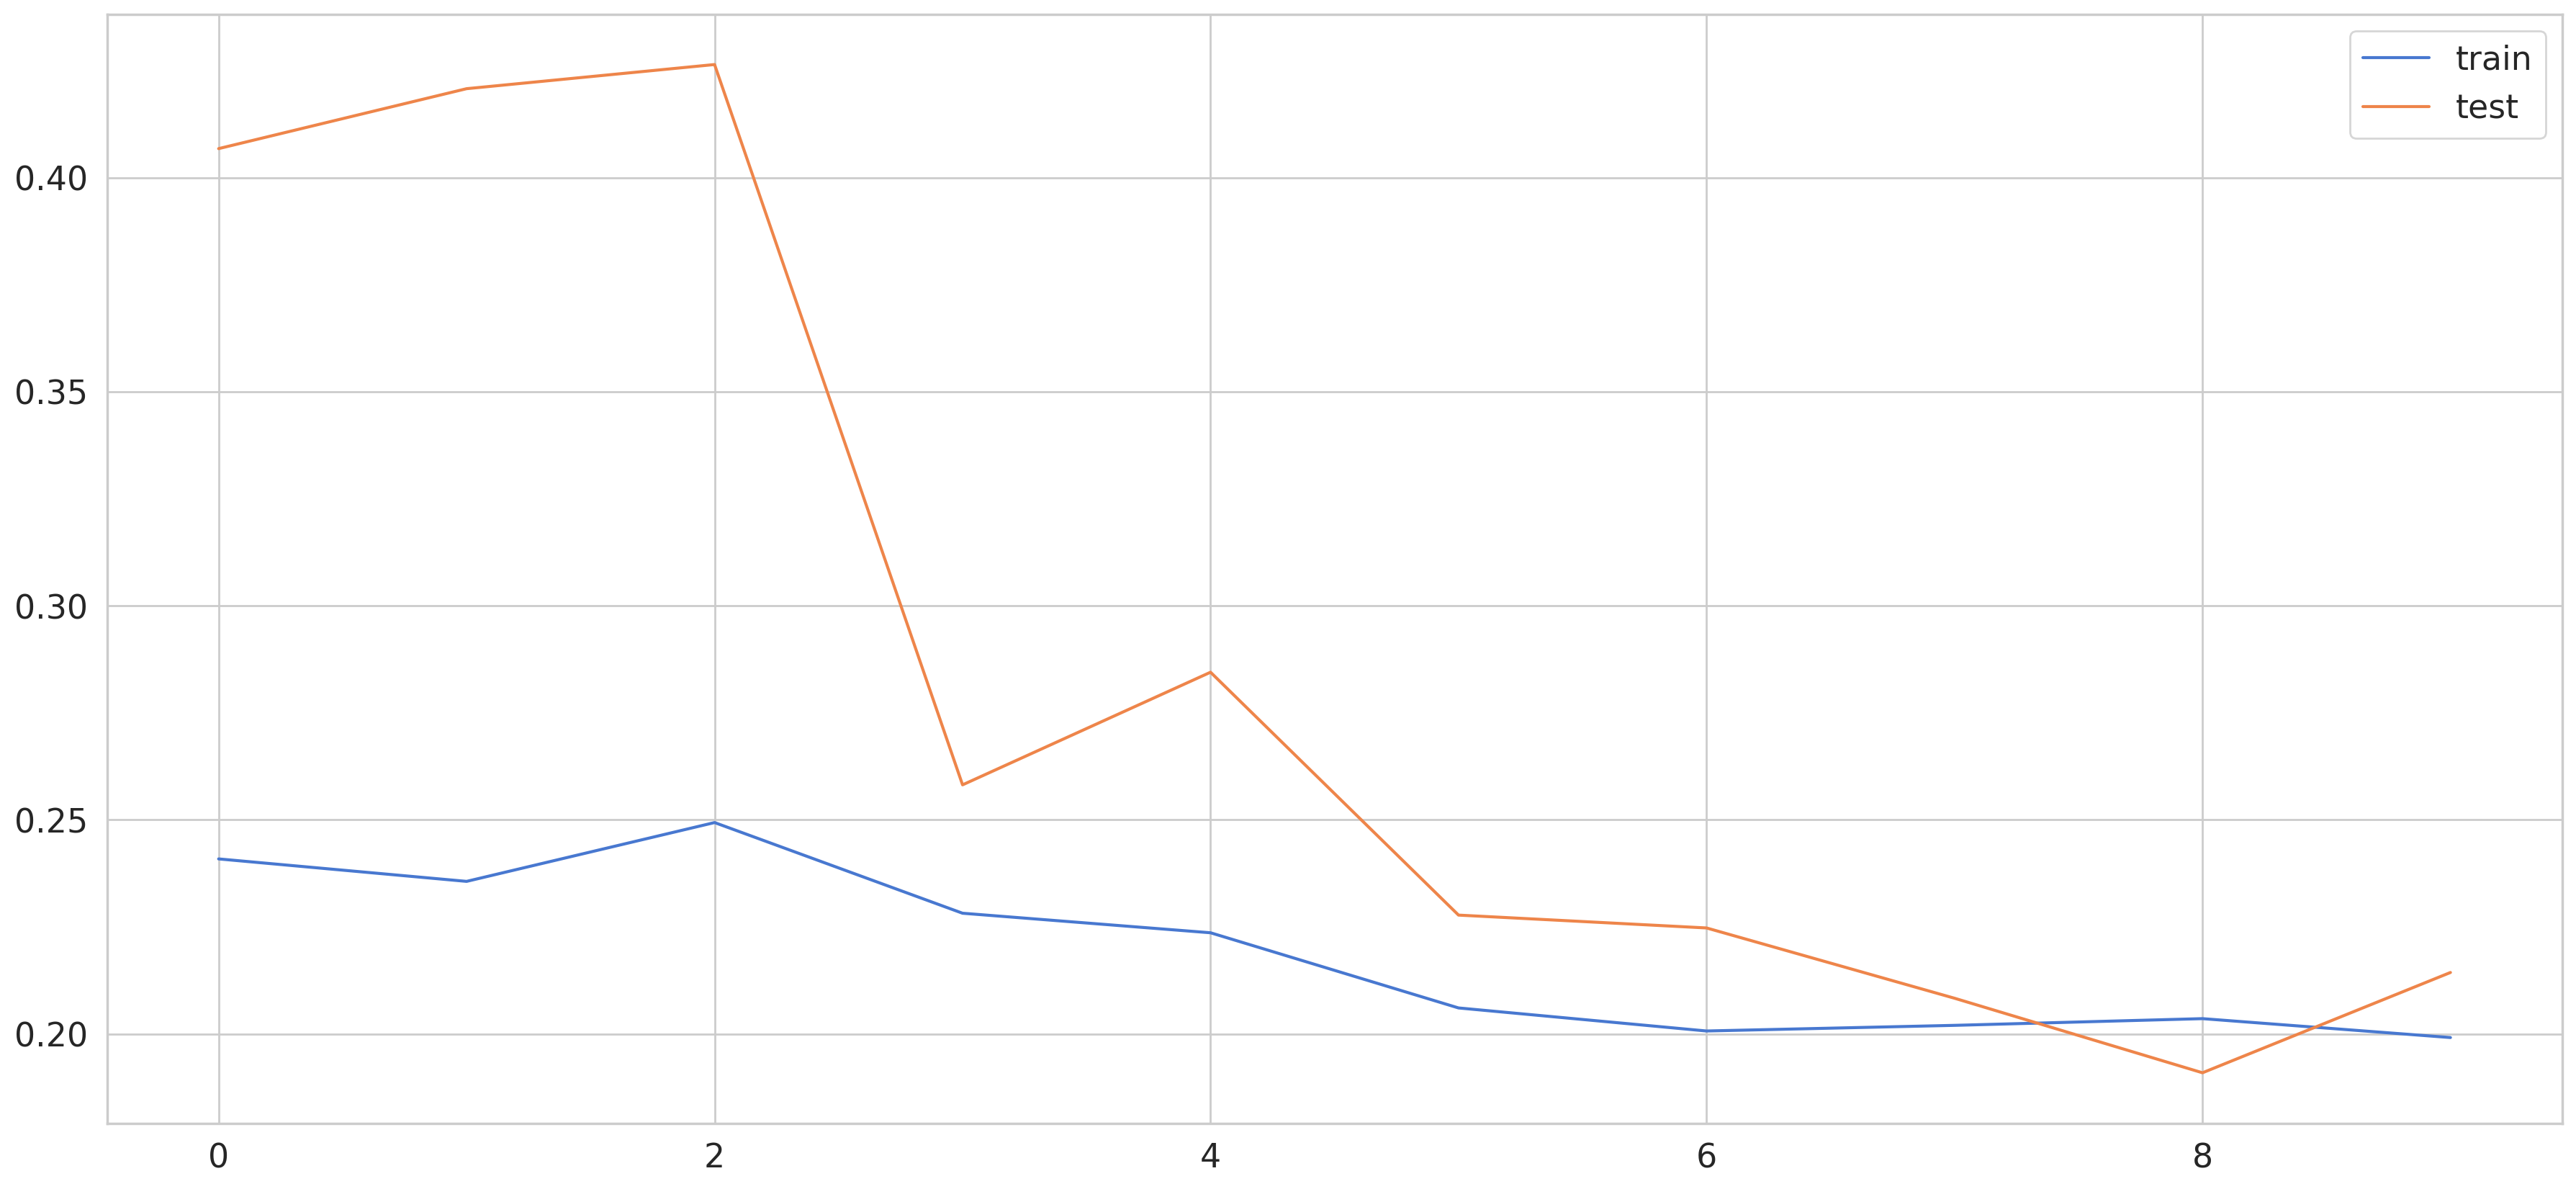

In [ ]:
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend();

In [ ]:
x_train_pred=model.predict(x_train)

77/77 [==============================] - 1s 3ms/step


In [ ]:
train_mae_loss=np.mean(np.abs(x_train_pred,x_train),axis=1)

In [ ]:
train_mae_loss.shape

(2438, 1)

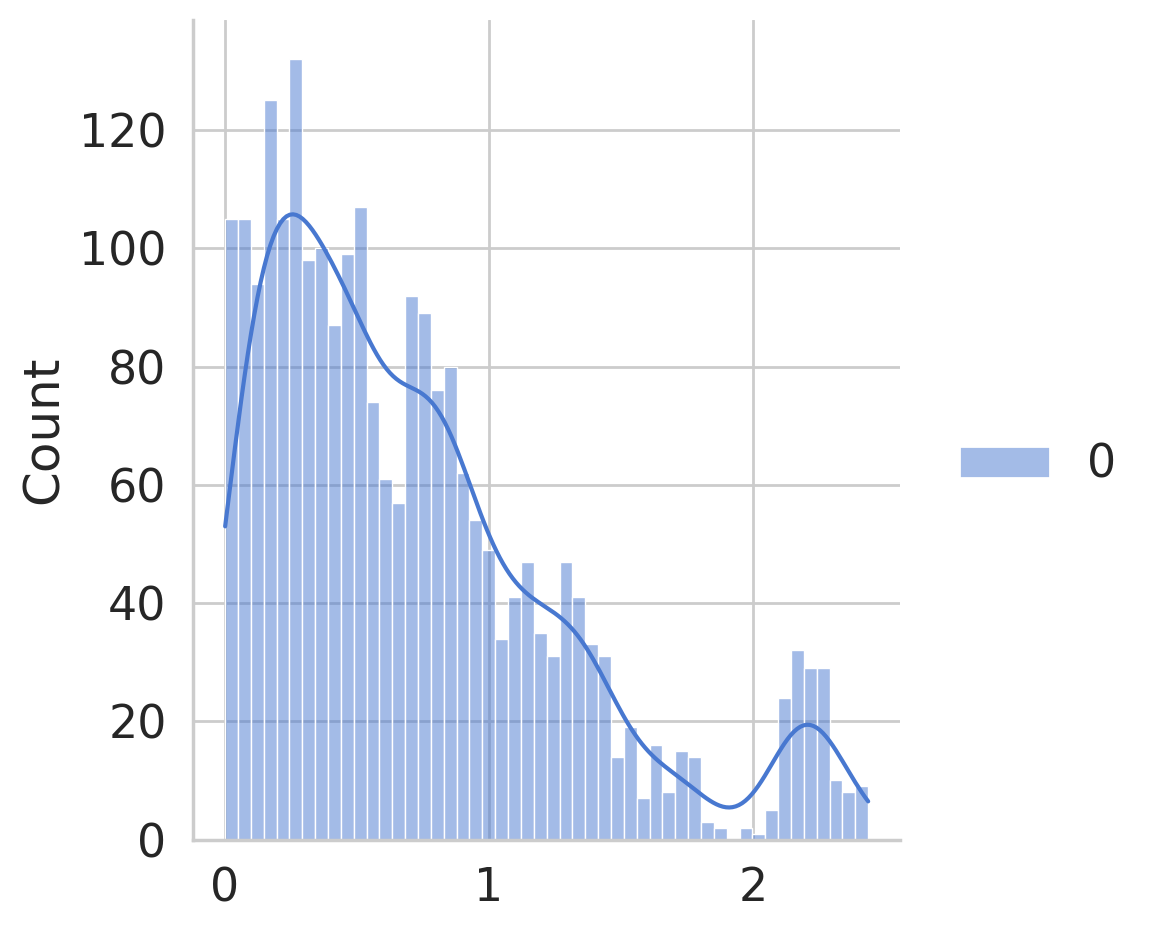

In [ ]:
sns.displot(train_mae_loss,bins=50,kde=True);

In [ ]:
x_test_pred=model.predict(x_test)
test_mae_loss=np.mean(np.abs(x_test_pred,x_test),axis=1)

4/4 [==============================] - 0s 4ms/step


In [ ]:
THRESHOLD=0.95
test_score_df=pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss']=test_mae_loss
test_score_df['threshold']=THRESHOLD
test_score_df['anomaly']=test_score_df.loss>test_score_df.threshold
test_score_df['Close']=test[TIME_STEPS:].Close

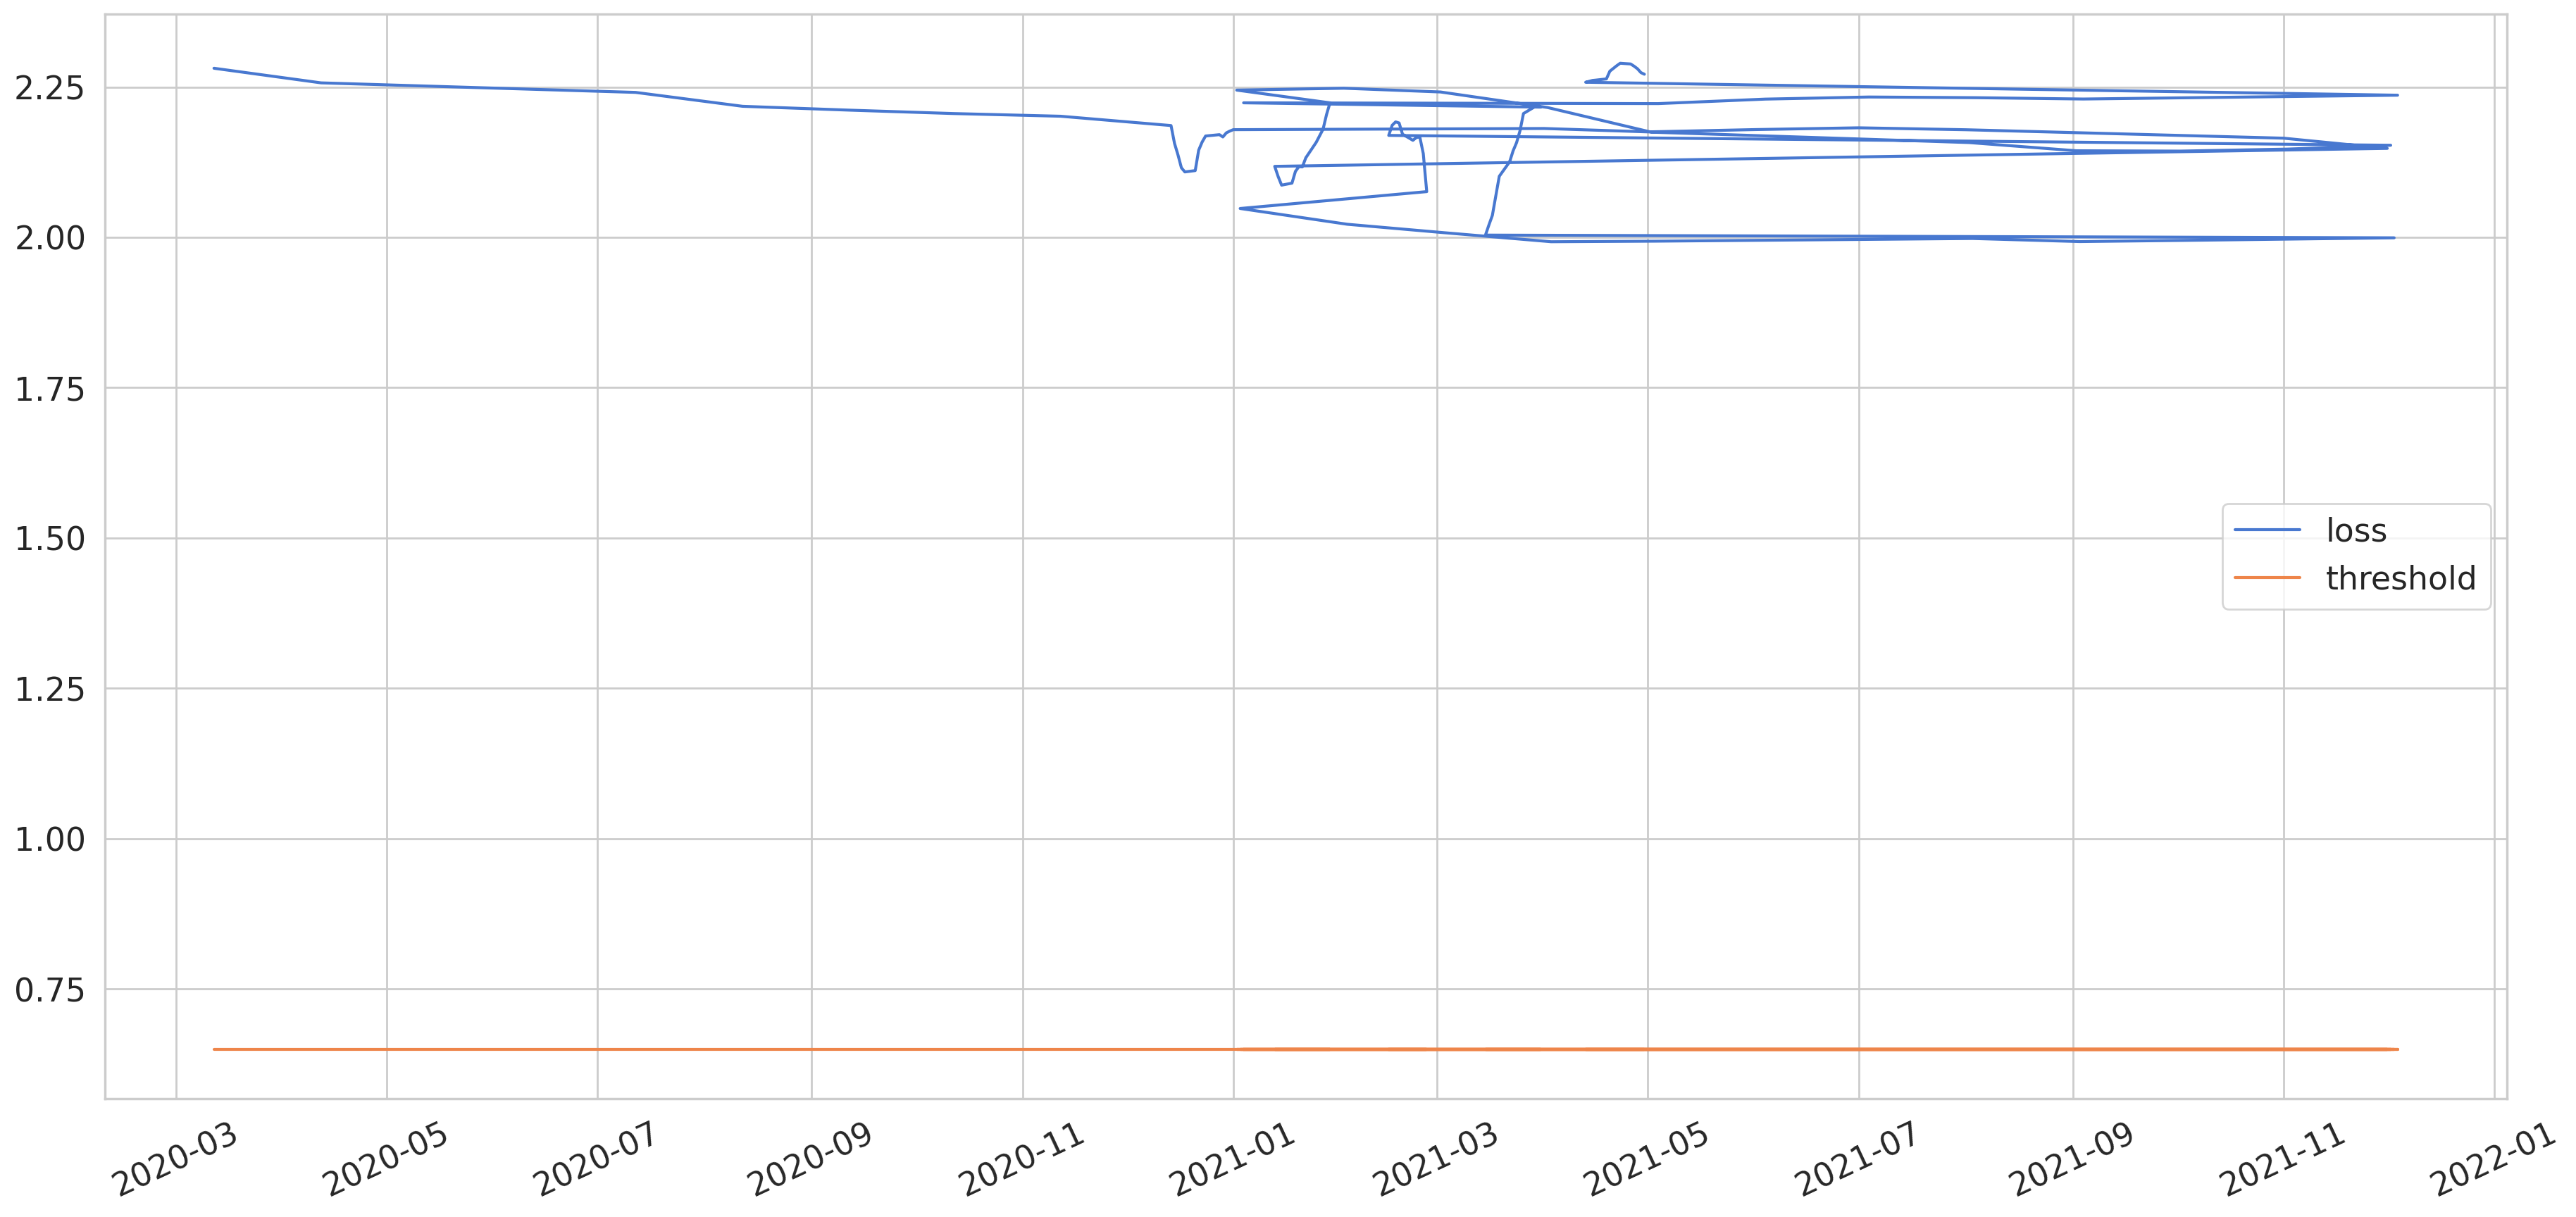

In [ ]:
plt.plot(test_score_df.index,test_score_df.loss,label='loss')
plt.plot(test_score_df.index,test_score_df.threshold,label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [ ]:
anomalies=test_score_df[test_score_df.anomaly==True]
anomalies.head()

,loss,threshold,anomaly,Close
Date,,,,
2020-03-12,2.281175,0.65,True,-2.436783
2020-04-12,2.256885,0.65,True,-2.439031
2020-07-12,2.241037,0.65,True,-2.386593
2020-08-12,2.217918,0.65,True,-2.424798
2020-09-12,2.211499,0.65,True,-2.418056


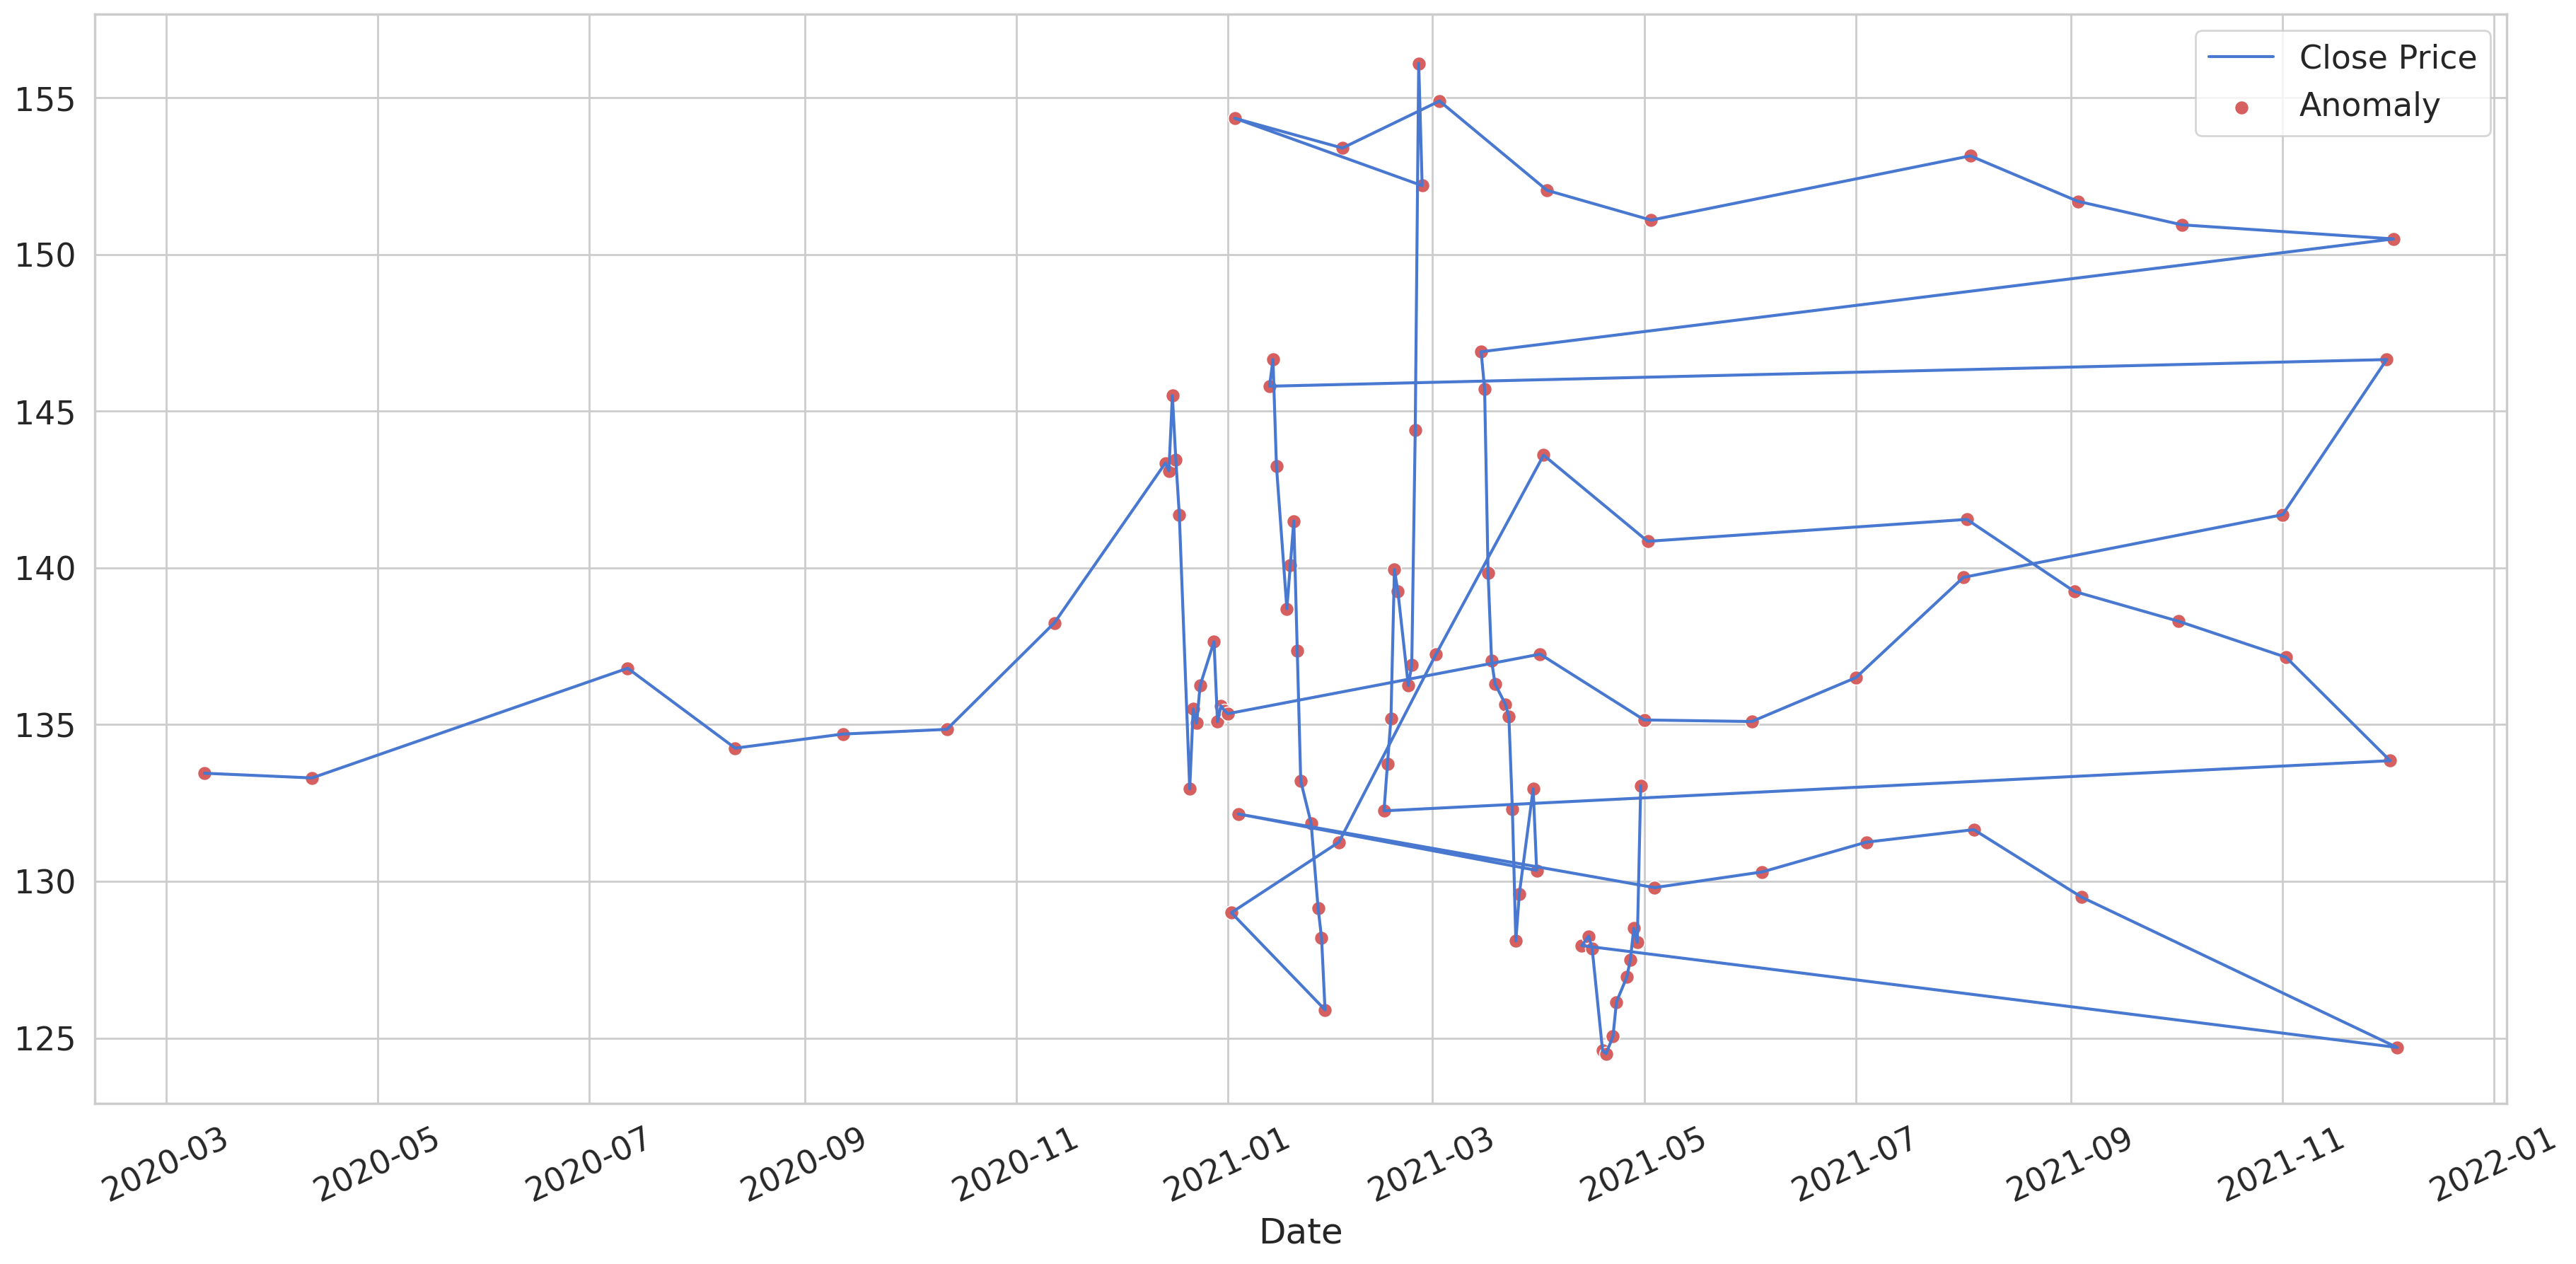

In [ ]:
plt.plot(
    test[TIME_STEPS:].index,
    scaler.inverse_transform(test[TIME_STEPS:].Close.values.reshape(1,-1)).reshape(-1),
    label='Close Price'
);

sns.scatterplot(
    x=anomalies.index,
    y=scaler.inverse_transform(anomalies.Close.values.reshape(1,-1)).reshape(-1),
    color=sns.color_palette()[3],
    s=52,
    label='Anomaly'
)
plt.xticks(rotation=25)
plt.legend();